# Plots with confidence interval

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import json
import numpy as np
from scipy.stats import t as student_variable

parameters = json.load(open("parameters.json"))

max_bellman_iterations = 2
max_bellman_iterations_validation = max_bellman_iterations + 5
n_seeds = 10
n_samples = parameters["n_discrete_states"] * parameters["n_discrete_actions"]
n_weights = parameters["n_weights"]
q_weights_dimension = 3

## Compute confidence intervals

In [2]:
def single_confidence_interval(mean, std, n_samples, confidence_level):
    t_crit = np.abs(student_variable.ppf((1 - confidence_level) / 2, n_samples - 1))
    lower_bound = mean - t_crit * (std / np.sqrt(n_samples))
    upper_bound = mean + t_crit * (std / np.sqrt(n_samples))

    return lower_bound, upper_bound

def confidence_interval(means, stds, n_samples, confidence_level=0.95):
    confidence_intervals = np.zeros((2, len(means)))

    for idx_iteration in range(len(means)):
        confidence_intervals[0, idx_iteration], confidence_intervals[1, idx_iteration] = single_confidence_interval(means[idx_iteration], stds[idx_iteration], n_samples, confidence_level)

    return confidence_intervals

## General case

### Extract data

In [3]:
fqi_w = np.zeros((n_seeds, max_bellman_iterations + 1, q_weights_dimension))

for idx_seed, seed in enumerate(range(1, n_seeds + 1)):
    fqi_w[idx_seed] = np.load(f"figures/data/FQI/{max_bellman_iterations}_W_{seed}.npy")

lspi_w = np.load(f"figures/data/LSPI/{max_bellman_iterations}_W.npy")

optimal_w = np.load(f"figures/data/optimal/W.npy")

pbo_linear_w = np.zeros((n_seeds, max_bellman_iterations_validation + 2, q_weights_dimension))

for idx_seed, seed in enumerate(range(1, n_seeds + 1)):
    pbo_linear_w[idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_W_{n_samples}_{n_weights}_{seed}.npy")

pbo_optimal_w = np.load(f"figures/data/PBO_optimal/{max_bellman_iterations}_W.npy")

### Distances with the optimal Q function

In [4]:
fqi_w_mean = np.sqrt(np.mean(np.square(fqi_w - optimal_w), axis=2)).mean(axis=0)
fqi_w_std = np.sqrt(np.mean(np.square(fqi_w - optimal_w), axis=2)).std(axis=0)
fqi_w_confidence_interval = confidence_interval(fqi_w_mean, fqi_w_std, n_seeds)

lspi_w_mean = np.sqrt(np.mean(np.square(lspi_w - optimal_w), axis=1))

pbo_linear_w_mean = np.sqrt(np.mean(np.square(pbo_linear_w - optimal_w), axis=2)).mean(axis=0)
pbo_linear_w_std = np.sqrt(np.mean(np.square(pbo_linear_w - optimal_w), axis=2)).std(axis=0)
pbo_linear_w_confidence_interval = confidence_interval(pbo_linear_w_mean, pbo_linear_w_std, n_seeds)

pbo_optimal_w_mean = np.sqrt(np.mean(np.square(pbo_optimal_w - optimal_w), axis=1))

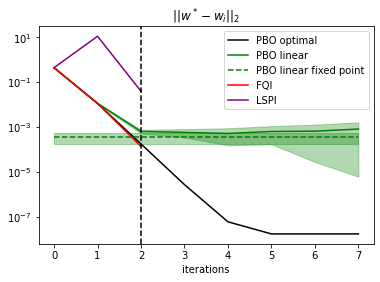

In [9]:
import matplotlib.pyplot as plt 

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_w_mean, label="PBO optimal", color="black")


plt.plot(iterations_validation, pbo_linear_w_mean[:-1], label="PBO linear", color="green")
plt.fill_between(iterations_validation, pbo_linear_w_confidence_interval[0, :-1], pbo_linear_w_confidence_interval[1, :-1], color="green", alpha=0.3)

plt.hlines(pbo_linear_w_mean[-1], 0, max_bellman_iterations_validation, color="green", linestyle="--", label="PBO linear fixed point")
plt.fill_between(iterations_validation, pbo_linear_w_confidence_interval[0, -1], pbo_linear_w_confidence_interval[1, -1], color="green", alpha=0.3)

plt.plot(iterations, fqi_w_mean, label="FQI", color="red")
plt.fill_between(iterations, fqi_w_confidence_interval[0], fqi_w_confidence_interval[1], color="red", alpha=0.3)

plt.plot(iterations, lspi_w_mean, label="LSPI", color="purple")

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(iterations_validation)
plt.xlabel("iterations")
plt.yscale("log")
plt.title(r"$|| w^* - w_i ||_2$")
plt.legend()
_ = plt.savefig(f"figures/distance_to_optimal_W_{max_bellman_iterations}.jpg", bbox_inches='tight')